# Análise de vinhos

Neste trabalho vamos utilizar a base de dados [Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews), disponível no [Kaggle](https://www.kaggle.com/).

A partir da análise desta base, vamos responder as seguintes perguntas:

1. Quais países produzem, em média, os melhores vinhos? E os piores?
2. Quais os melhores e piores vinhos em relação a custo/benefício?
3. Qual o tipo de uva mais comum por país?
4. Quais vinícolas possuem a maior variação de preços? E de nota?
5. Há como prever o tipo de uva a partir da descrição do vinho?

## Visão geral da base

Primeiramente, vamos dar uma olhada na base para descobrir seus atributos.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('dataset/winemag-data-130k-v2.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Alguns atributos não serão utilizados para responder nossas perguntas. O primeiro atributo, sem nome, será eliminado, bem como os atributos `designation`, `provice`, `region_1`, `region_2`, `taster_name` e `taster_twitter_handler`.

In [2]:
df.drop(['Unnamed: 0', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle'], axis=1, inplace=True)

 Com isso, estamos prontos para responder as perguntas!

## 1. Quais países produzem, em média, os melhores vinhos? E os piores?

Para descobrir, vamos simplesmente agrupar a base por país, calcular a média dos pontos e ordenar de forma decrescente. Vamos pegar os cinco primeiros e os cinco últimos.

In [3]:
nota_media_por_pais = df.groupby('country')['points'].mean().sort_values(ascending=False)
melhores_paises = nota_media_por_pais[:5]
piores_paises = nota_media_por_pais[-5:]

Agora, vamos plotar um gráfico de barras para ver o resultado. Os países que produzem os melhores vinhos estão em azul, enquanto os que produzem os piores estão em vermelho.

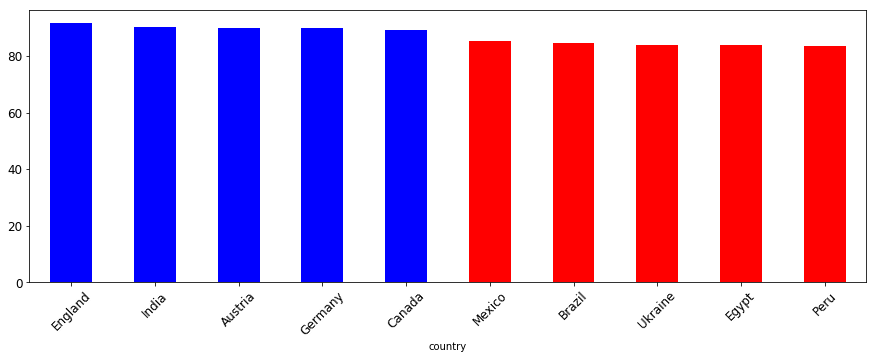

In [5]:
melhores_paises.append(piores_paises).plot.bar(x='country', y='points', color=(['blue'] * 5) + (['red'] * 5), figsize=(15,5), fontsize='large', rot=45)

A primeira coisa que nós verificamos é a ausência de muitos países tradicionais, como França, Itália, Portugal e Argentina. Imagino que deve ser pelo fato de eles produzirem muitos vinhos, e com isso a média cai. Para nos certificarmos, vamos descobrir a quantidade de vinhos por país.

In [6]:
numero_de_vinhos_por_pais = df.groupby('country').size().sort_values(ascending=False)
print(numero_de_vinhos_por_pais)

country
US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14


Nossas suspeitas se confirmaram. Inglaterra e Índia, que foram os dois países mais bem colocados, possuem, respectivamente, 74 e 9 vinhos na base, enquanto os países tradicionais que mencionamos possuem mais de 1000. Vamos então levar em conta apenas países que fabricam mais de 1000 vinhos para ver os resultados.

In [7]:
paises_tradicionais = numero_de_vinhos_por_pais[numero_de_vinhos_por_pais >= 1000].index.values

nota_media_por_pais_tradicional = df[df['country'].isin(paises_tradicionais)].groupby('country')['points'].mean().sort_values(ascending=False)
melhores_paises_tradicionais = nota_media_por_pais_tradicional[:5]
piores_paises_tradicionais = nota_media_por_pais_tradicional[-5:]

Vamos plotar o gráfico novamente para ver as diferenças.

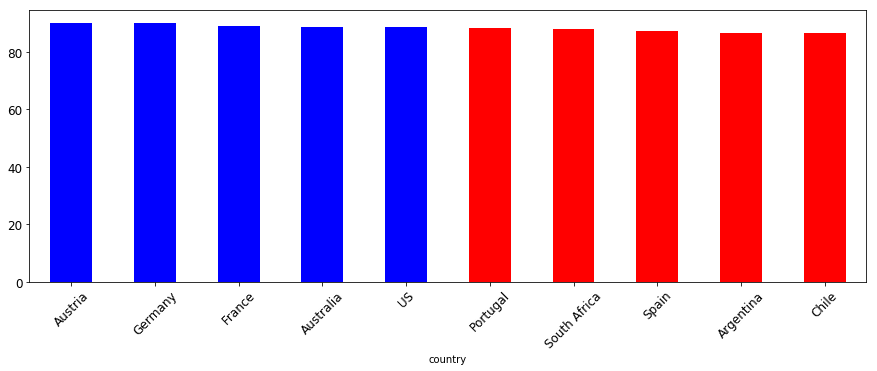

In [8]:
melhores_paises_tradicionais.append(piores_paises_tradicionais).plot.bar(x='country', y='points', color=(['blue'] * 5) + (['red'] * 5), figsize=(15,5), fontsize='large', rot=45)

Com isso, verificamos que, dentre os tradicionais países produtores de vinhos, os que produzem os vinhos mais bem avaliados são Áustria e Alemanha, enquanto os que produzem os menos bem avaliados são Argentina e Chile.

# 2. Quais os melhores e piores vinhos em relação a custo/benefício?

Para saber o custo/benefício, temos que levar em conta a proporção entre o preço do vinho e sua nota. Vamos criar uma coluna nova chamada `price_per_point`, que irá ser a divisão entre as colunas `points` e `price`.

Para isso, porém, precisamos garantir que as colunas `points` e `price` estejam preenchidas, para evitar problemas de divisão por zero ou NaN. Vamos eliminar as linhas que não possuem as colunas `points` ou `price` preenchidas.

In [9]:
df.dropna(subset=['points','price'], inplace=True)

Em seguida, vamos criar a nova coluna, `price_per_point` e ordenar por esta nova coluna, de forma decrescente, o que mostrará os piores custos-benefícios primeiro.

In [10]:
df['price_per_point'] = df['price']/df['points']
df.sort_values(by='price_per_point', ascending=False)[['price_per_point', 'price', 'points', 'title']]

,price_per_point,price,points,title
80290,37.500000,3300.0,88,Château les Ormes Sorbet 2013 Médoc
98380,26.041667,2500.0,96,Domaine du Comte Liger-Belair 2010 La Romanée
15840,26.041667,2500.0,96,Château Pétrus 2014 Pomerol
120391,22.120879,2013.0,91,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...
113564,20.833333,2000.0,96,Domaine du Comte Liger-Belair 2005 La Romanée
65352,20.618557,2000.0,97,Château Pétrus 2011 Pomerol
1558,19.387755,1900.0,98,Château Margaux 2009 Margaux
111753,15.000000,1500.0,100,Château Lafite Rothschild 2010 Pauillac
111755,15.000000,1500.0,100,Château Cheval Blanc 2010 Saint-Émilion
1575,13.541667,1300.0,96,Château Mouton Rothschild 2009 Pauillac


Podemos perceber que os piores custos-benefícios são referentes aos vinhos muito caros, que custam centenas ou milhares de dólares a garrafa. Temos que separar os vinhos em categorias de preço e analisar o custo-benefício separadamente por categoria.

Vamos ver qual a faixa de preço dos vinhos da base.

In [11]:
df['price'].describe()[['min', 'max']]

min       4.0
max    3300.0
Name: price, dtype: float64

O vinho mais barato da base custa 4 dólares, enquanto o mais caro custa 3.300 dólares. Vamos separar os vinhos em cinco categorias de preço e avaliá-las separadamente.

In [12]:
df['category'] = pd.cut(df['price_per_point'], 5, precision=2, labels=['\$', '\$\$', '\$\$\$', '\$\$\$\$', '\$\$\$\$\$'])

Vamos então calcular o custo-benefício por categoria.

In [13]:
custo_beneficio_por_categoria = df.groupby('category')['price_per_point', 'title']

### Piores custos-benefícios por categoria

In [14]:
custo_beneficio_por_categoria.max()

,price_per_point,title
category,,
\$,7.473684,Štoka 2011 Izbrani Teran (Kras)
\$\$,15.000000,W. & J. Graham's NV 90-year Old Tawny (Port)
\$\$\$,22.120879,Domaine du Comte Liger-Belair 2005 La Romanée
\$\$\$\$,26.041667,Domaine du Comte Liger-Belair 2010 La Romanée
\$\$\$\$\$,37.500000,Château les Ormes Sorbet 2013 Médoc


### Melhores custos-benefícios por categoria

In [15]:
custo_beneficio_por_categoria.min()

,price_per_point,title
category,,
\$,0.046512,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès)
\$\$,7.724490,Biondi Santi 2006 Riserva (Brunello di Montal...
\$\$\$,19.387755,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...
\$\$\$\$,26.041667,Château Pétrus 2014 Pomerol
\$\$\$\$\$,37.500000,Château les Ormes Sorbet 2013 Médoc


Percebemos que na categoria `$$$$$`, o mesmo vinho (_Château les Ormes Sorbet 2013 Médoc_) foi listado como pior e melhor custo-benefício. Isso ocorre porque ele é o único vinho na categoria.

## 3. Qual o tipo de uva mais comum por país?

Vamos plotar um mapa do mundo onde a cor dos países será de acordo com o tipo de uva mais comum nos vinhos produzidos.

Primeiro, vamos precisar descobrir qual o tipo de uva mais comum por país.

In [16]:
uva_por_pais = df.groupby(['country', 'variety']).size().rename('total').to_frame()
uva_mais_comum_por_pais = uva_por_pais[uva_por_pais['total'] == uva_por_pais.groupby(['country'])['total'].transform(max)].copy()
uva_mais_comum_por_pais.reset_index(['country', 'variety'], inplace=True)

Agora, vamos verificar se há países em que há mais de um tipo de uva que seja igualmente comum.

In [17]:
uva_mais_comum_por_pais[uva_mais_comum_por_pais.duplicated(subset=['country', 'total'], keep=False)]

,country,variety,total
1,Armenia,Kangoun,1
2,Armenia,Rosé,1
5,Bosnia and Herzegovina,Blatina,1
6,Bosnia and Herzegovina,Vranec,1
14,Czech Republic,Cabernet Moravia,2
15,Czech Republic,Red Blend,2
16,Czech Republic,Sauvignon Blanc,2
27,Luxembourg,Riesling,2
28,Luxembourg,Sparkling Blend,2
29,Macedonia,Pinot Noir,3


Como podemos ver, há 7 países nesta situação. Como são países que produzem poucos vinhos, vamos retirá-los do gráfico final para facilitar.

In [18]:
uva_mais_comum_por_pais.drop_duplicates(subset=['country','total'], keep=False, inplace=True)
uva_mais_comum_por_pais.set_index('country', inplace=True)

Agora, vamos plotar o mapa do mundo com os países que sobraram, coloridos de acordo com o tipo de uva. Vamos utilizar a biblioteca [GeoPandas](http://geopandas.org/), que já vem com um mapa do mundo embutido. Vamos dar uma olhada no formato deste objeto.

In [19]:
import geopandas as gpd

mapa_do_mundo = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

mapa_do_mundo.head(10)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...
5,2967004.0,Asia,Armenia,ARM,18770.0,"POLYGON ((43.58274580259273 41.09214325618257,..."
6,3802.0,Antarctica,Antarctica,ATA,760.4,(POLYGON ((-59.57209469261153 -80.040178725096...
7,140.0,Seven seas (open ocean),Fr. S. Antarctic Lands,ATF,16.0,"POLYGON ((68.935 -48.62500000000001, 69.58 -48..."
8,21262641.0,Oceania,Australia,AUS,800200.0,(POLYGON ((145.3979781434948 -40.7925485166058...
9,8210281.0,Europe,Austria,AUT,329500.0,"POLYGON ((16.97966678230404 48.12349701597631,..."


É basicamente um dataframe com uma lista de países, mas há uma coluna chamada `geometry` que diz como ele deve ser desenhado. Vamos mesclá-lo com o dataframe `uva_mais_comum_por_pais`, assim o dataframe resultante terá também o tipo de uva mais comum daquele país.

Antes disso, temos que verificar se todos os nomes de países do dataframe `uva_mais_comum_por_pais` estão presentes no dataframe `mapa_do_mundo`.

In [20]:
mapa_do_mundo.set_index('name', inplace=True)
uva_mais_comum_por_pais.index.difference(mapa_do_mundo.index)

Index(['England', 'US'], dtype='object')

Inglaterra e Estados Unidos não foram encontrados no dataframe `mapa_do_mundo`. Provavelmente, eles estão escritos de forma diferente. Vamos tentar localizá-los através da coluna `iso_a3`, que representa o código ISO de 3 letras dos países. O da Inglaterra é **GBR** (de Grã-Bretanha) e o dos Estados Unidos é **USA**.

In [21]:
mapa_do_mundo[mapa_do_mundo['iso_a3'].isin(['GBR', 'USA'])]

,pop_est,continent,iso_a3,gdp_md_est,geometry
name,,,,,
United Kingdom,62262000.0,Europe,GBR,1977704.0,(POLYGON ((-5.661948614921897 54.5546031764838...
United States,313973000.0,North America,USA,15094000.0,"(POLYGON ((-155.54211 19.08348000000001, -155...."


No dataframe `mapa_do_mundo`, Inglaterra e Estados Unidos estão listados como United Kingdom e United States, respectivamente. Já no dataframe `uva_mais_comum_por_pais`, estão listados como England e US, respectivamente. Vamos alterar estes nomes antes de mesclá-los.

In [22]:
uva_mais_comum_por_pais.rename(index={'England': 'United Kingdom', 'US': 'United States'}, inplace=True)

Agora, vamos realizar a mesclagem e dar uma olhada nos dados.

In [23]:
mapa_do_mundo_com_tipos_de_uva = mapa_do_mundo.join(uva_mais_comum_por_pais)
mapa_do_mundo_com_tipos_de_uva.head()

,pop_est,continent,iso_a3,gdp_md_est,geometry,variety,total
name,,,,,,,
Afghanistan,28400000.0,Asia,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",NaN,NaN
Angola,12799293.0,Africa,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...,NaN,NaN
Albania,3639453.0,Europe,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",NaN,NaN
United Arab Emirates,4798491.0,Asia,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,...",NaN,NaN
Argentina,40913584.0,South America,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...,Malbec,1499.0


Os países que não estavam presentes no dataframe `uva_mais_comum_por_pais` ficaram com o valor `NaN` nas colunas `variety` e `total`.

Vamos substituir este valor `NaN` pela string `None`, senão teremos problemas na hora de colorir o mapa. A coluna `total` não precisa ser alterada, pois não fará parte do gráfico.

In [24]:
mapa_do_mundo_com_tipos_de_uva['variety'].fillna('None', inplace=True)

Só falta mais um ajuste antes de plotar o mapa. Queremos que os países sem vinhos (ou seja, que estão com a coluna `variety` com o valor `None`) fiquem com a cor cinza.

Temos que ver qual a posição do valor `None` na lista ordenada de tipos de uva, pois teremos que alterar a mesma posição na lista de cores.

In [25]:
tipos_de_uva = mapa_do_mundo_com_tipos_de_uva['variety'].unique()
tipos_de_uva.sort()
indice = np.where(tipos_de_uva == 'None')[0][0]
indice

7

Com isso, sabemos que temos que alterar a cor no índice 7 da lista de cores para cinza. Vamos criar um colormap customizado a partir do colormap [tab20b](https://matplotlib.org/examples/color/colormaps_reference.html) do Matplotlib.

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cores_customizadas = list(plt.cm.get_cmap('tab20b').colors)
cores_customizadas[indice] = (0.8509803921568627, 0.8509803921568627, 0.8509803921568627) # cinza claro

colormap_customizado = ListedColormap(cores_customizadas)

Finalmente, vamos plotar o resultado final.

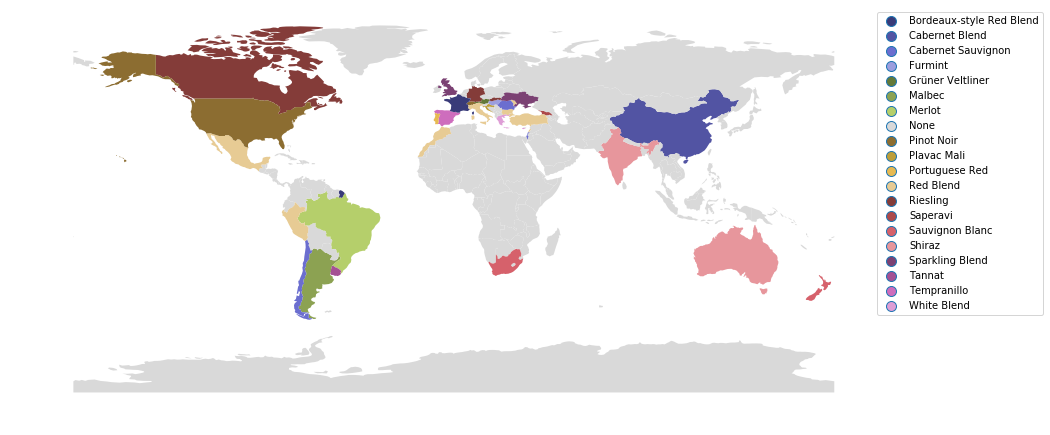

In [27]:
ax = mapa_do_mundo_com_tipos_de_uva.plot(column='variety', cmap=colormap_customizado, figsize=(15,10), legend=True)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 1, 0.21, 0))

## 4. Quais vinícolas possuem a maior variação média de preços? E de nota?

Como há muitas vinícolas, vamos nos limitar apenas às dez vinícolas com maior variação média, tanto de preços quanto de nota. Também vamos restringir apenas às vinícolas que possuem pelo menos dez vinhos. Depois, vamos mostrar os resultados num gráfico.

Vamos criar uma coluna concatenando a vinícola e o país, para melhor visualizar a informação no gráfico, e para evitar vinícolas com o mesmo nome e países diferentes sendo tratadas como a mesma vinícola.

In [28]:
df['winery_country'] = df['winery'] + ' (' + df['country'] + ')'

In [29]:
vinicolas_com_pelo_menos_dez_vinhos = df.groupby('winery_country').filter(lambda x: len(x) >= 10)

In [30]:
vinicolas_agrupadas_por_variacao_preco = vinicolas_com_pelo_menos_dez_vinhos.groupby('winery_country')['price'].std().sort_values(ascending = False)
vinicolas_agrupadas_por_variacao_nota = vinicolas_com_pelo_menos_dez_vinhos.groupby('winery_country')['points'].std().sort_values(ascending = False)

vinicolas_com_maior_variacao_preco = vinicolas_agrupadas_por_variacao_preco[:10].index.values
vinicolas_com_maior_variacao_nota = vinicolas_agrupadas_por_variacao_nota[:10].index.values

Primeiro, vamos plotar o gráfico da variabilidade de preços.

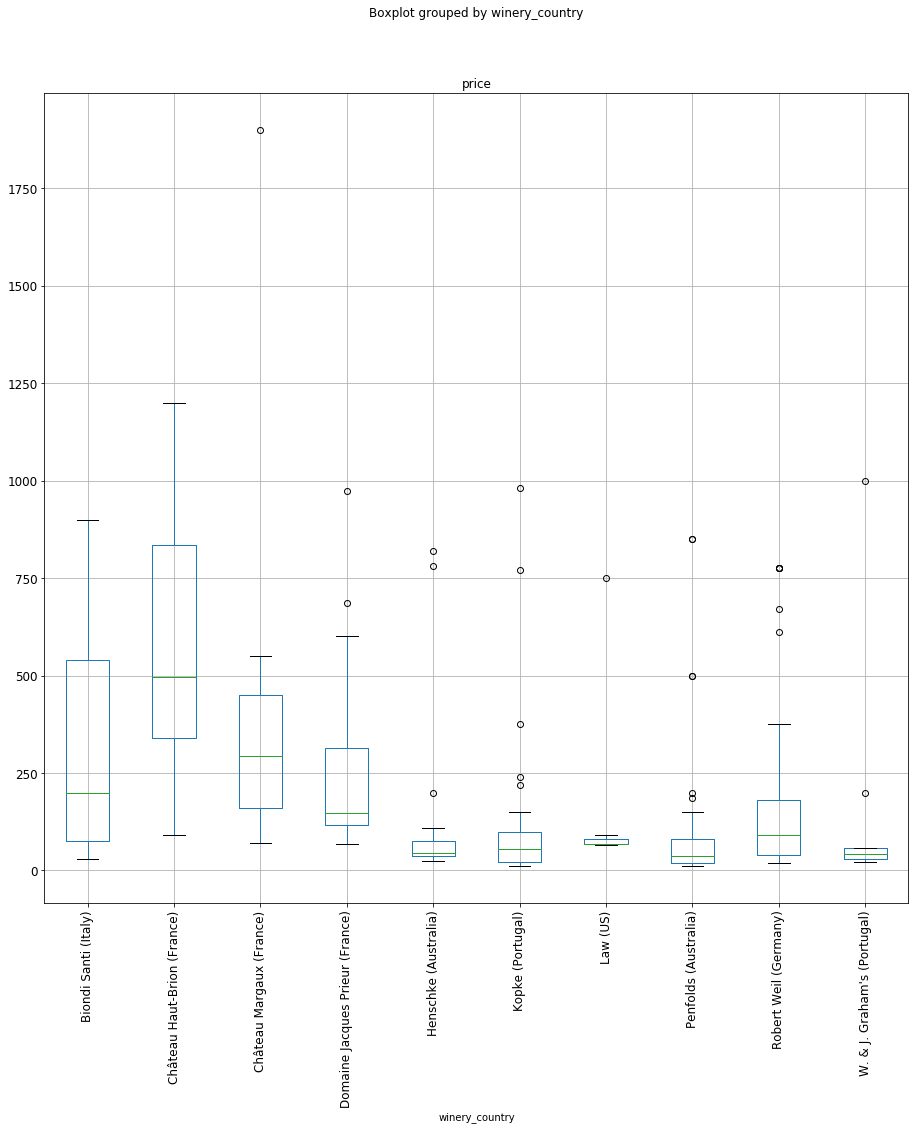

In [31]:
df[df['winery_country'].isin(vinicolas_com_maior_variacao_preco)].boxplot(by='winery_country', column=['price'], rot=90, figsize=(15,15), fontsize='large')

De acordo com o boxplot acima, fica fácil perceber que a vinícola Château Margaux, da França, é que possui a maior variabilidade de preços entre os vinhos. Veja que tem um único outlier, muito mais caro que os outros vinhos, que faz essa variabilidade aumentar. Vamos dar uma olhada no maior e menor preço dessa vinícola.

In [32]:
precos_vinicola_maior_variabilidade_precos = df[df['winery_country'] == 'Château Margaux (France)']['price']
print('Mais caro: {}'.format(precos_vinicola_maior_variabilidade_precos.max()))
print('Mais barato: {}'.format(precos_vinicola_maior_variabilidade_precos.min()))

Mais caro: 1900.0
Mais barato: 70.0


Agora, vamos fazer o mesmo para descobrir a vinícola com a maior variabilidade média de nota.

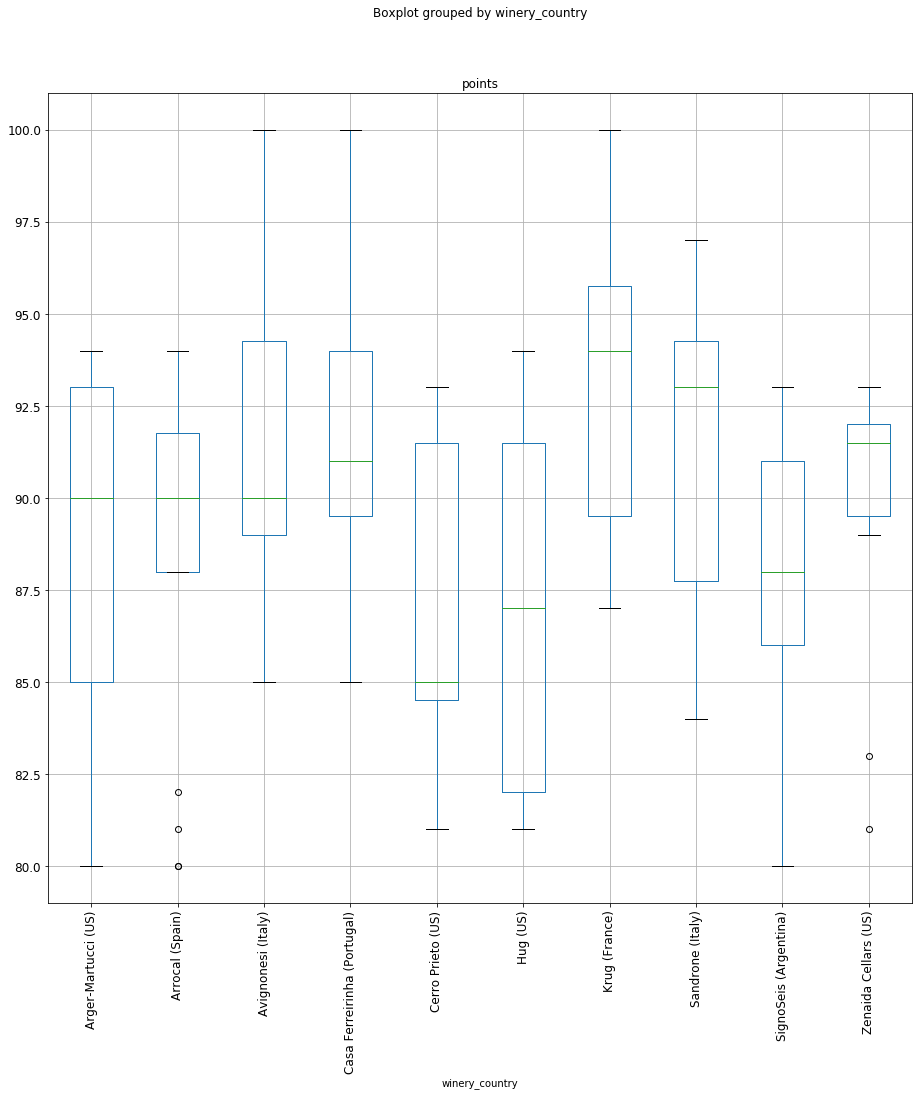

In [33]:
df[df['winery_country'].isin(vinicolas_com_maior_variacao_nota)].boxplot(by='winery_country', column=['points'], rot=90, figsize=(15,15), fontsize='large')

Nesse caso, ficou difícil de perceber através do gráfico. Vamos ver qual é a vinícola com maior variabilidade de preços através da lista ordenada que nós obtemos anteriormente.

In [34]:
vinicolas_agrupadas_por_variacao_nota[[0]]

winery_country
Hug (US)    4.870246
Name: points, dtype: float64

Descobrimos então que a vinícola em questão é a Hug, dos Estados Unidos. Vamos dar uma olhada na maior e menor nota dessa vinícola.

In [35]:
notas_vinicola_maior_variabilidade_notas = df[df['winery_country'] == 'Hug (US)']['points']
print('Mais bem avaliado: {}'.format(notas_vinicola_maior_variabilidade_notas.max()))
print('Menos bem avaliado: {}'.format(notas_vinicola_maior_variabilidade_notas.min()))

Mais bem avaliado: 94
Menos bem avaliado: 81


## 5. Há como prever o tipo de uva a partir da descrição do vinho?

Por fim, vamos utilizar o algoritmo **Random Forest Classifier** para tentar prever o tipo de uva a partir da descrição do vinho. Para isso, temos que, de alguma forma, transformar a coluna `description` em um valor numérico para que possamos utilizar o algoritmo.

Primeiramente, vamos utilizar a biblioteca NLTK para extrair apenas os adjetivos da descrição. A partir disso, vamos gerar uma nova coluna, `keywords`, contendo apenas os adjetivos, separados por vírgulas.

In [36]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

def obter_keywords(row):
    tokens = nltk.word_tokenize(row['description'])
    tags = nltk.pos_tag(tokens)
    adjectives = set([word for word,pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS')]) ## JJ, JJR e JJS são os códigos que representam adjetivos no NLTK
    return ','.join(adjectives)

df['keywords'] = df.apply(obter_keywords, axis=1)

Vamos dar uma olhada na base para ver como ficou essa nova coluna.

In [37]:
df[['title', 'country', 'description', 'keywords']].head(10)

,title,country,description,keywords
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portugal,"This is ripe and fruity, a wine that is smooth...","ripe,red,drinkable"
2,Rainstorm 2013 Pinot Gris (Willamette Valley),US,"Tart and snappy, the flavors of lime flesh and...","snappy,lime,crisp,stainless-steel,green"
3,St. Julian 2013 Reserve Late Harvest Riesling ...,US,"Pineapple rind, lemon pith and orange blossom ...","honey-drizzled,semidry,lemon,astringent,opulent"
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,US,"Much like the regular bottling from 2012, this...","rough,Much,regular,herbal,earthy,rustic,tannic..."
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Spain,Blackberry and raspberry aromas show a typical...,"herbal,typical,fresh,dark,green,tomatoey,full"
6,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Italy,"Here's a bright, informal red that opens with ...","white,informal,soft,fresh,candied,bright"
7,Trimbach 2012 Gewurztraminer (Alsace),France,This dry and restrained wine offers spice in p...,"restrained,dry,much,firm"
8,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Germany,Savory dried thyme notes accent sunnier flavor...,"accent,sunnier,elegant,fresh,preserved,thyme,o..."
9,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,France,This has great depth of flavor with its fresh ...,"dry,pear,fresh,crisp,great"
10,Kirkland Signature 2011 Mountain Cuvée Caberne...,US,"Soft, supple plum envelopes an oaky structure ...","attractive,value-priced,complete,immediate,oak..."


A ideia agora é transformar cada adjetivo destes numa coluna numérica. Se o adjetivo estiver presente na descrição, o valor da coluna será 1. Caso contrário, será 0.

Vamos contar quantos adjetivos diferentes existem na coluna `keywords`, apenas nas 100 primeiras linhas, para saber se isto é viável.

In [38]:
print('Número de adjetivos diferentes nas 100 primeiras linhas: {}'.format(len(set(df['keywords'].head(100).str.split(',').sum()))))

Número de adjetivos diferentes nas 100 primeiras linhas: 278


Levando em conta apenas as 100 primeiras linhas, teríamos que criar 278 novas colunas na base. Já dá pra perceber que, ao levar em conta toda a base com suas 130 mil linhas, isso não seria viável.

Temos que reduzir o número total de adjetivos. Para isso, utilizaremos uma lista de adjetivos tipicamente usados para descrever vinhos. Um artigo na Wikipedia, intitulado [Wine tasting descriptors](https://en.wikipedia.org/wiki/Wine_tasting_descriptors), contém uma lista desses adjetivos. Vamos então manter na coluna `keywords` apenas os adjetivos que façam parte desta lista.

Primeiro, precisamos obter a lista de adjetivos do artigo com o auxílio da biblioteca `BeautifulSoup`.

In [39]:
import re
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen

site = Request('https://en.wikipedia.org/wiki/Wine_tasting_descriptors', headers={'User-Agent': 'Mozilla/5.0'})
pagina = urlopen(site).read().decode('utf-8', 'ignore')
soup = BeautifulSoup(pagina, 'lxml')

wine_adjectives = set([adj.lower() for adj in re.findall('<li><b>(\w+)<\/b>:', pagina)])

print('Total de adjetivos: {}'.format(len(wine_adjectives)))

Total de adjetivos: 80


Como pudemos verificar, a lista possui apenas 80 adjetivos. Agora, temos que manter na coluna `keywords` apenas os adjetivos pertencentes a esta lista.

In [40]:
def manter_keywords_tipicas(row):
    return ','.join(wine_adjectives.intersection(set(row['keywords'].split(','))))

df['keywords'] = df.apply(manter_keywords_tipicas, axis=1)

Vamos dar uma olhada em como ficou a coluna `keywords`.

In [41]:
df['keywords'].head(10)

1                               
2                    green,crisp
3                     astringent
4     herbal,rough,earthy,tannic
5        herbal,fresh,green,full
6                     soft,fresh
7                       dry,firm
8                  elegant,fresh
9                dry,fresh,crisp
10                          oaky
Name: keywords, dtype: object

Como pudemos ver, há algumas linhas que ficaram em branco, pois não possuíam os mesmos adjetivos da lista que obtivemos do artigo da Wikipedia. Há também algumas linhas com apenas um ou dois adjetivos, que provavelmente não serão muito úteis para realizar a predição. Vamos então manter apenas as linhas que contém pelo menos quatro adjetivos.

In [42]:
filtered_df = df[df['keywords'].str.split(',').map(len) >= 4].copy()

Agora, vamos transformar cada adjetivo da lista numa coluna, inicialmente com o valor 0.

In [43]:
filtered_df[list(wine_adjectives)] = pd.DataFrame([np.zeros(len(wine_adjectives))], index=filtered_df.index)

Preencheremos então essa coluna com 1 caso o adjetivo correspondente esteja presente na coluna `keywords`.

In [44]:
for adj in wine_adjectives:
    filtered_df[adj] = filtered_df.apply(lambda row: float(int(adj in row['keywords'])), axis=1)

Vamos nos livrar das outras colunas, pois não serão necessárias. Vamos manter apenas a coluna `variety`, que é a que queremos prever, além das novas colunas dos adjetivos.

In [45]:
filtered_df.drop(['country', 'description', 'points', 'price', 'title', 'winery', 'price_per_point', 'category', 'winery_country', 'keywords'], axis=1, inplace=True)

Agora, podemos aplicar o algoritmo. Vamos separar o dataframe em dois: um de treinamento e um de testes.

In [46]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(0)

filtered_df['is_train'] = np.random.uniform(0, 1, len(filtered_df)) <= .75

train, test = filtered_df[filtered_df['is_train'] == True], filtered_df[filtered_df['is_train'] == False]

Precisamos também transformar o tipo da uva em um número.

In [47]:
variety_number, variety_name = pd.factorize(train['variety'])

Vamos agora criar o classificador Random Forest e treiná-lo.

In [48]:
clf = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=100)

clf.fit(train[wine_adjectives], variety_number)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Agora vamos aplicar o classificador nos dados de teste.

In [49]:
preds = clf.predict(test[wine_adjectives])
preds_varieties = variety_name[preds]

Vamos imprimir a matriz de confusão apenas para dar uma olhada geral. Mas, como são muitas colunas, não vai ser fácil visualizar.

In [50]:
pd.crosstab(test['variety'], preds_varieties, rownames=['Tipo de uva verdadeiro'], colnames=['Tipo de uva predito'])

Tipo de uva predito,Albariño,Alsace white blend,Arinto,Blaufränkisch,Bonarda,Bordeaux-style Red Blend,Bordeaux-style White Blend,Cabernet,Cabernet Franc,Cabernet Sauvignon,...,Trincadeira,Verdicchio,Vernaccia,Vidal Blanc,Viognier,Weissburgunder,White Blend,Zierfandler,Zinfandel,Zweigelt
Tipo de uva verdadeiro,,,,,,,,,,,,,,,,,,,,,
Albariño,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alvarinho,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aragonês,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arinto,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Baga,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Barbera,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blaufränkisch,0,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Bonarda,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bordeaux-style Red Blend,0,0,0,0,0,7,0,0,1,8,...,0,0,0,0,0,1,0,0,1,0


Vamos ver agora o score do modelo.

In [51]:
from sklearn.metrics import accuracy_score

accuracy_score(test['variety'], preds_varieties)

0.2255083179297597

Conseguimos prever apenas 22,5% dos tipos de uvas corretamente. Provavelmente o trabalho de separar a descrição apenas nos adjetivos não foi suficiente. Talvez tivéssemos que incluir também alguns substantivos para melhorar o modelo.